In [1]:
import gurobipy as gb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import random
from scipy.spatial.distance import euclidean
from scipy.stats import truncnorm
import pickle
import os
from source import *

path = os.getcwd()

# Global variables

In [2]:
''' Non-linear charging function parameters '''
energy_bps = [0,212.5,237.5,250] # Energy level (miles) breakpoints in the piecewise linear function
charging_rates = [260.1,118.575,39.525] # Charging rates (miles/hour) for every piece in the charging function
full_rch_time = 1.344086022 # Time that it would take for a vehicle to recharge until full range (250 miles) with an empty battery


# Functions

In [3]:
def nl_charging_function(soc):

    p = [i for i in range(3) if energy_bps[i]<=soc and soc<=energy_bps[i+1]][0]
    return full_rch_time - sum((min(soc,energy_bps[pp+1])-energy_bps[pp])/charging_rates[pp] for pp in range(p+1))

def dump_parameters(sc,mu,sigma,K,r,S_k,K_s,tp,p,a,t):
    
    file = open(path+f"/Sensitivity/Data/K/K_mu{mu}_sigma{sigma}_sc{sc}", "wb")
    pickle.dump(K,file); file.close()

    file = open(path+f"/Sensitivity/Data/r/r_mu{mu}_sigma{sigma}_sc{sc}", "wb")
    pickle.dump(r,file); file.close()

    file = open(path + f'/Sensitivity/Data/S_k/Sk_mu{mu}_sigma{sigma}_sc{sc}', 'wb')
    pickle.dump(S_k, file); file.close()

    file = open(path + f'/Sensitivity/Data/K_s/Ks_mu{mu}_sigma{sigma}_sc{sc}', 'wb')
    pickle.dump(K_s, file); file.close()

    file = open(path + f"/Sensitivity/Data/tp/tp_mu{mu}_sigma{sigma}_sc{sc}", "wb")
    pickle.dump(tp,file); file.close()

    file = open(path + f'/Sensitivity/Data/p/p_mu{mu}_sigma{sigma}_{sc}', 'wb')
    pickle.dump(p, file); file.close()

    file = open(path + f'/Sensitivity/Data/a t/at_mu{mu}_sigma{sigma}_{sc}', 'wb')
    pickle.dump((a,t), file); file.close()


def generate_stochastic_parameters(mu, sigma, distances, S):

    ''' Import vehicles dataframe'''
    vehicles = pd.read_csv(path+"/Data/Definite Vehicles.csv",index_col=[0])
    file = open(path+"/Data/closest_10_stations","rb")
    closest_10 = pickle.load(file); file.close()
    file = open(path+"/Data/closest_distance","rb")
    closest_distance = pickle.load(file); file.close()

    ''' Demand parameters for truncated normal distribution '''
    loc, scale, min_v, max_v = mu, sigma, 20, 250
    aa, b = (min_v - loc) / scale, (max_v - loc) / scale

    ''' Import other parameters '''
    file = open(path+"/Data/Global/dem_distribution","rb")
    dem_distribution = pickle.load(file); file.close()
    dem_time_steps = list(range(len(dem_distribution)))

    ''' Scenario generation '''
    flag = True
    ii = -1
    while flag:
        ii += 1
        flag = False
        ranges, realized = dict(), dict()

        for i in vehicles.index:
            feas = False
            rr = truncnorm.rvs(a = aa, b = b, loc = loc, scale = scale, size = 1)
            ranges[i] = rr[0]

            prob = np.exp(-0.012**2*(rr-20)**2)
            realization = random.choice([True,False], p = [prob[0], 1-prob[0]])
            realized[i] = realization

            if realization == True:
                if rr >= closest_distance[i]:
                    feas = True
                else:
                    flag = True
                    print(f'\tAttempt n. {ii} failed at vehicle {i}')
                    break
    
    K = [k for k in vehicles.index if realized[k]]
    r = {k:ranges[k] for k in K}
    tp = {k:random.choice(dem_time_steps,p=dem_distribution) for k in K}

    ''' Compute other parameters '''
    S_k = {k:[s for s in closest_10[k] if s in S and distances[s,k]<=r[k]] for k in K}
    K_s = {s:[k for k in K if s in S_k[k]] for s in S}

    return K, r, tp, S_k, K_s

def get_optimal_solution():
    file = open(path+"/Results/Optimal/S","rb")
    S = pickle.load(file); file.close()

    file = open(path+"/Results/Optimal/n","rb")
    n = pickle.load(file); file.close()

    file = open(path+"/Results/Optimal/distances","rb")
    distances = pickle.load(file); file.close()

    return S, n, distances

def run_scenario(mu,sigma,sc):

    ''' Import station configuration, number of chargers and distance matrix '''
    S, n, distances = get_optimal_solution()

    ''' Import global parameters '''
    file = open(path+"/Data/Global/driving_speed","rb")
    driving_speed = pickle.load(file); file.close()
    
    ''' Generate stochastic parameters of scenario '''
    K, r, tp, S_k, K_s = generate_stochastic_parameters(mu,sigma,distances,S)
    
    p = {(k,s):250-(r[k]-distances[s,k]) for s in S for k in K_s[s]}
    t = {(k,s):nl_charging_function(r[k]-distances[s,k])  for s in S for k in K_s[s]}
    a = {(k,s):distances[s,k]/driving_speed+tp[k]/4 for s in S for k in K_s[s]}
    a.update({("s",s):0 for s in S}); a.update({("e",s):30 for s in S})
    t.update({("s",s):0 for s in S}); t.update({("e",s):0 for s in S})

    ''' Saves scenario parameters '''
    dump_parameters(sc,mu,sigma,K,r,S_k,K_s,tp,p,a,t)

    results = test_scenario_sensitivity(S,K,K_s,n,a,t)

    print("\--------------------RESULTS--------------------")
    print(f"A total of {len(K)} vehicles need to be assigned")
    print(f"Total assigned vehicles: {len(results['total_total'])}")
    print(f"Total unassigned vehicles: {len(results['infeasible'])}")
    print(f"Achieved Service Level: {round(100*(1-len(results['infeasible'])/len(K)),2)}")

    return results


In [4]:
mu = 110; sigmas = [20,50,80]
for sc in range(100):
    for sigma in sigmas:
        results = run_scenario(mu,sigma,sc)
        file = open(path+f"/Sensitivity/Results/results_mu{mu}_sigma{sigma}_sc{sc}","wb")
        pickle.dump(results,file); file.close()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-07
		Iteration 0:		MP obj: 3545.0	time: 0.02s
		Iteration 1:		MP obj: 14.0	time: 15.33s
		Iteration 2:		MP obj: 0.0	time: 15.55s
		Iteration 3:		MP obj: 0.0	time: 15.58s
		Iteration 4:		MP obj: 0.0	time: 15.61s
		Iteration 5:		MP obj: 0.0	time: 15.62s
		Iteration 6:		MP obj: 0.0	time: 15.64s
		Iteration 7:		MP obj: 0.0	time: 15.66s
	IMP obj: 0.0	Optimality gap: 0.0

--------------------RESULTS--------------------
A total of 3545 vehicles need to be assigned
	Total assigned vehicles: 3545
	Total unassigned vehicles: 0
Achieved Service Level: 100.0
	Attempt n. 0 failed at vehicle 10730
		Iteration 0:		MP obj: 3929.0	time: 0.0s
		Iteration 1:		MP obj: 23.34	time: 19.58s
		Iteration 2:		MP obj: 1.0	time: 19.97s
		Iteration 3:		MP obj: 1.0	time: 19.98s
		Iteration 4:		MP obj: 1.0	time: 20.05s
		Iteration 5:		MP obj: 1.0	time: 20.08s
		Iteration 6:		MP obj: 1.0	time: 20.12s
		Iteration 7:		MP obj: 1.0	tim

In [4]:
mu = 100; sigmas = [20,50,80]
np.random.seed(seed=65434)
for sc in range(70,100):
    for sigma in sigmas:
        results = run_scenario(mu,sigma,sc)
        file = open(path+f"/Sensitivity/Results/results_mu{mu}_sigma{sigma}_sc{sc}","wb")
        pickle.dump(results,file); file.close()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-07
		Iteration 0:		MP obj: 4462.0	time: 0.02s
		Iteration 1:		MP obj: 33.86	time: 23.89s
		Iteration 2:		MP obj: 3.05	time: 24.34s
		Iteration 3:		MP obj: 0.0	time: 24.56s
		Iteration 4:		MP obj: 0.0	time: 24.56s
		Iteration 5:		MP obj: 0.0	time: 24.59s
	IMP obj: 5.0	Optimality gap: 0.0

--------------------RESULTS--------------------
A total of 4462 vehicles need to be assigned
	Total assigned vehicles: 4457
	Total unassigned vehicles: 5
Achieved Service Level: 99.89
		Iteration 0:		MP obj: 4449.0	time: 0.02s
		Iteration 1:		MP obj: 51.31	time: 27.66s
		Iteration 2:		MP obj: 5.84	time: 28.31s
		Iteration 3:		MP obj: 1.3	time: 28.53s
		Iteration 4:		MP obj: 0.0	time: 28.66s
		Iteration 5:		MP obj: 0.0	time: 28.67s
		Iteration 6:		MP obj: 0.0	time: 28.7s
		Iteration 7:		MP obj: 0.0	time: 28.72s
		Iteration 8:		MP obj: 0.0	time: 28.73s
		Iteration 9:		MP obj: 0.0	time: 28.78s
		Iteration 10:		MP obj: 

In [4]:
mu = 80; sigmas = [20,50,80]
random.seed(871263)
iter = 1
for sc in range(0,50):
    if sc > 9:
        print(f"\n------------------------------ Scenario {sc} - {round(100*iter/120,2)}% ------------------------------")
        for sigma in sigmas:
            results = run_scenario(mu,sigma,sc)
            file = open(path+f"/Sensitivity/Results/results_mu{mu}_sigma{sigma}_sc{sc}","wb")
            pickle.dump(results,file); file.close()
            iter += 1


------------------------------ Scenario 10 - 0.83% ------------------------------
Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-11
		Iteration 0:		MP obj: 6396.0	time: 0.03s
		Iteration 1:		MP obj: 328.39	time: 96.0s
		Iteration 2:		MP obj: 160.55	time: 108.26s
		Iteration 3:		MP obj: 108.54	time: 120.59s
		Iteration 4:		MP obj: 74.44	time: 135.29s
		Iteration 5:		MP obj: 53.52	time: 151.77s
		Iteration 6:		MP obj: 40.92	time: 171.55s
		Iteration 7:		MP obj: 31.4	time: 194.23s
		Iteration 8:		MP obj: 25.82	time: 220.22s
		Iteration 9:		MP obj: 21.28	time: 249.89s
		Iteration 10:		MP obj: 18.48	time: 281.78s
		Iteration 11:		MP obj: 15.77	time: 315.61s
		Iteration 12:		MP obj: 14.03	time: 350.7s
		Iteration 13:		MP obj: 12.88	time: 390.78s
		Iteration 14:		MP obj: 11.45	time: 432.44s
		Iteration 15:		MP obj: 10.04	time: 474.53s
		Iteration 16:		MP obj: 8.95	time: 518.18s
		Iteration 17:		MP obj: 8.46	time: 557.47s
		Iteration 18:		MP obj: 7.34	

# Plots

In [10]:
mu = [80,100,110]
sigma = [20,50,80]

ranges = {80:50,100:0,110:0}

K = dict(); serv_level = dict()

for m in mu:
    for s in sigma:
        K[m,s] = list(); serv_level[m,s] = list()
        for sc in range(ranges[m],100):
            file = open(path+f"/Sensitivity/Results/results_mu{m}_sigma{s}_sc{sc}","rb")
            results = pickle.load(file); file.close()

            K[m,s].append(len(results["total_total"]) + len(results["infeasible"]))
            serv_level[m,s].append(1-len(results["infeasible"])/K[m,s][-1])
                

Text(0.5, 0.98, 'Service Level Sensitivity Analysis from\nInitial Available Driving Range')

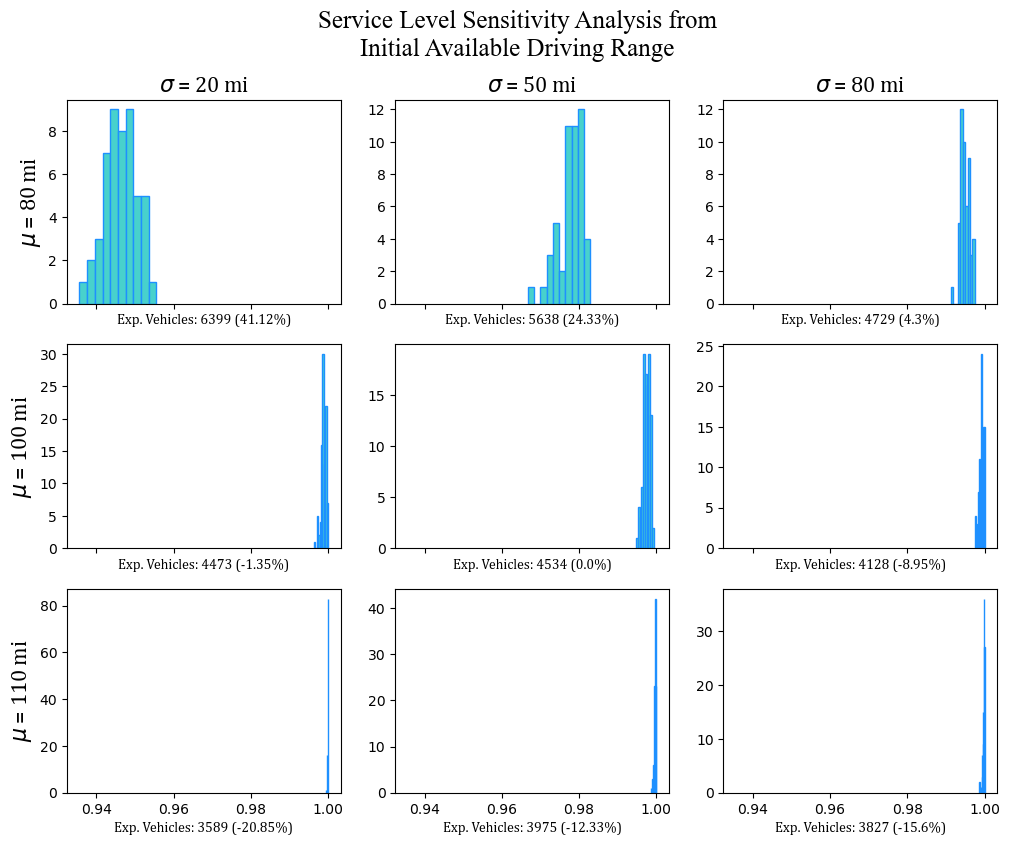

In [13]:
fig, subp = plt.subplots(figsize=(12,9),sharex=True,nrows=3,ncols=3)

axes = {}; i = 0; j = 0
for m in mu:
    for s in sigma:
        axes[m,s] = subp[i,j]
        if j == 2: i += 1; j = 0
        else: j += 1


base = np.mean(K[100,50])
for m in mu:
    for s in sigma:
        
        axes[m,s].hist(serv_level[m,s],edgecolor="dodgerblue",color="mediumturquoise")
        dem = np.mean(K[m,s])
        ss = f"Exp. Vehicles: {int(dem)} ({round(100*(dem/base-1),2)}%)"
        axes[m,s].set_xlabel(ss,fontsize=10,fontname="Cambria")

        if m == mu[0]: axes[m,s].set_title(r"$\sigma$" + f" = {s} mi",fontsize=16,fontname="Cambria")
        if s == sigma[0]: axes[m,s].set_ylabel(r"$\mu$" + f" = {m} mi",fontsize=16,fontname="Cambria")

fig.suptitle("Service Level Sensitivity Analysis from\nInitial Available Driving Range",fontname="Times New Roman",fontsize=18)